# Reading AFNI BRIK & HEAD files in Python.

Here is a description of the header contents:
    https://afni.nimh.nih.gov/pub/dist/doc/program_help/README.attributes.html
    
In Matlab you can read BRIK files using this function: https://github.com/PrincetonUniversity/princeton-mvpa-toolbox/blob/master/afni_matlab/BrikLoad.m

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from afni import *

In [3]:
fname = "TT_N27+tlrc" # make sure you have downloaded (and g-unzipped it)
hdr,dat = read_afni(fname)

In [4]:
dat.shape

(161, 191, 151, 1)

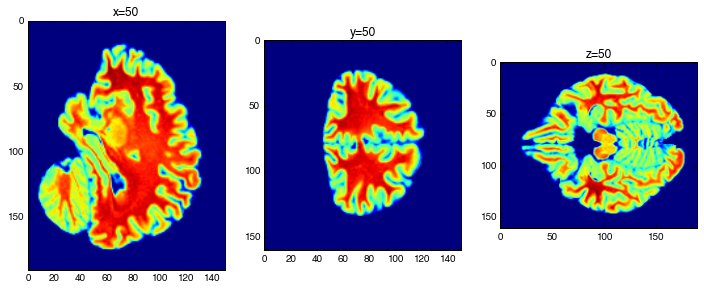

In [5]:
f, axarr = plt.subplots(1, 3, figsize=(12,5.5))
axarr[0].imshow(dat[50,:,:,0])
axarr[0].set_title("x=50")
axarr[1].imshow(dat[:,50,:,0])
axarr[1].set_title("y=50")
axarr[2].imshow(dat[:,:,50,0])
axarr[2].set_title("z=50")

Show one slice from an EPI image.

In [6]:
#header["BRICK_TYPES"]
fname = "pb05.s04.pre.r01.blur+tlrc"
hdr,dat = read_afni(fname)

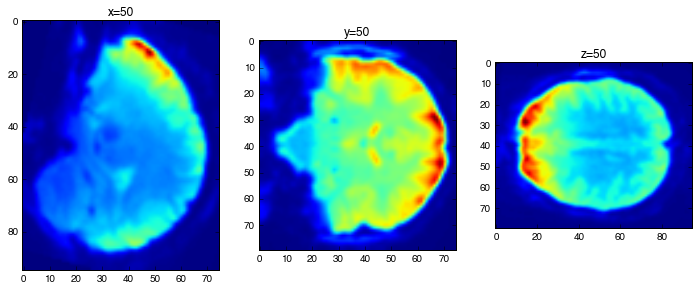

In [7]:
f, axarr = plt.subplots(1, 3, figsize=(12,5.5))
tr = 10
axarr[0].imshow(dat[50,:,:,tr])
axarr[0].set_title("x=50")
axarr[1].imshow(dat[:,50,:,tr])
axarr[1].set_title("y=50")
axarr[2].imshow(dat[:,:,50,tr])
axarr[2].set_title("z=50")

Plot a time series of one voxel.

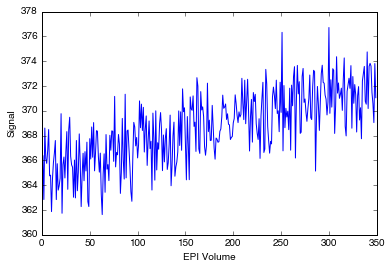

In [8]:
ts = dat[50,50,50,:]
plot(ts)
xlabel("EPI Volume")
ylabel("Signal")